<a href="https://colab.research.google.com/github/AnjaliSifar/GutToyModel/blob/main/serendipity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Generic code**

In [1]:
#@title
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import random
import time
from tqdm import tqdm

from datetime import datetime
import os,errno

In [2]:
#@title
def createDir(dir):
  try:
      os.mkdir(dir)
      print("created directory",dir)
  except OSError as e:
      if e.errno == errno.EEXIST:
          print('Directory ',dir,'already exists.')
      else:
          raise  

In [3]:
#@title
def writeParameters():
  if saveFig:
    now = datetime.now()
    dt_string = now.strftime("%d/%m/%Y %H:%M:%S")

    createDir(folder)
    
    params = """ SIMULATION RAN ON : {dt}
    number of iterations = {0}
    first slice for graph plotting, plotN = {1}
    step size, history recorded at every step size  = {2}
    
    
    plot selection variables : choice = {ps1}, number of data points for representation = {ps2}
    in case of a random slice of history:start = {ps3}, stop = {ps4}, step = {ps5}
    
    
    BEHAVIOUR PARAMETERS 
    =======================
    # nutrients = {b1}
    state slicer = {b2}
    action slicer = {b3}

    shapes of stm, state space, action space = {b4},{b5},{b6}


    GUT PARAMETERS
    ===============
    Growth constant = {g1}
    Decay constant = {g2}
    K = {g3}
    per bacteria contribution = {g4}

    BRAIN PARAMETERS
    ==================
    alpha = {bb1}
    gamma = {bb2}
    epsilon = {bb3}

    """.format(iterations,plotN,stepSize
    ,b1 = behavior.nNutrients,b2 = behavior.stateSlicer,b3 = behavior.actionSlicer
    ,b4 = behavior.stm.shape,b5 = len(behavior.stateSet),b6 = len(behavior.actionSet)
    ,b7 = behavior.stateSet,b8 = behavior.actionSet
    ,g1 = gut.gc,g2 = gut.dc,g3 = gut.K,g4 = gut.contribution
    ,bb1 = brain.alpha,bb2 = brain.gamma, bb3 = brain.epsilon
    ,ps1 = choice, ps2 = plotDataPoints, ps3 = start, ps4 = stop, ps5 = step
    ,dt = dt_string
    )

    with open(folder+"parameters.txt", "a") as file:
        file.write(params)


In [4]:
#@title
def generatePlotSel(choice = 'random',**kwargs):
    sel = np.arange(5)
    if choice == 'random':
        n = kwargs.get('n',5)
        randSel = np.random.randint(0,iterations,n)
        randSel.sort()
        sel =  randSel
    elif choice == 'all':
        sel = np.arange(iterations)
    elif choice == 'custom':
        start = kwargs.get('start',0)
        stop = kwargs.get('stop',5)
        step = kwargs.get('step',1)
        sel = np.arange(start,stop,step)
    
    else:
        print("first five selection only.")
    return sel



# **System**

In [5]:
#@title
   
class Brain:
    def __init__(self, behavior, **kwargs):

        # Params
        self.alpha = kwargs.get('alpha', 0.1)
        self.gamma = kwargs.get('gamma', 0.05)
        self.epsilon = kwargs.get('epsilon', 0.1)
        
        self.time = kwargs.get('time', 1)  #for debugging

        # for convenience
        self.nActions = len(behavior.actionSet)
        self.nStates = len(behavior.stateSet)

        # To be computed
        self.qTable = np.zeros((self.nStates,self.nActions))
        self.oStateInd = behavior.stateInd
        self.oActionInd = None


    def do(self,stateInd):
        self.oStateInd= stateInd
        if(np.random.random() > self.epsilon):
            actionInd = self.exploit(stateInd)
        else:
            actionInd = self.explore()

        self.oActionInd = actionInd
        return self.oActionInd

        

    def learn(self,newstate, reward):
        
        old_q = self.qTable[self.oStateInd,self.oActionInd]
        maxFutureQ = max(self.qTable[newstate, :])

        self.qTable[self.oStateInd, self.oActionInd] = old_q + self.alpha*(reward +                 self.gamma*maxFutureQ - old_q)

# For debugging only
        # delta = self.qTable[self.oStateInd, self.oActionInd] - old_q
        # if self.time%100 == 0:
        #     print(""" delta = {0:.4f} , old q= {1:.3f}, new q = {2:.3f}
        #         """.format(delta,old_q,self.qTable[self.oldStateIndex, self.oldActionIndex]))

        
           
    def exploit(self,stateInd):
        possibleActionValues = self.qTable[stateInd, :]
        maxActionInd = np.where(possibleActionValues == max(possibleActionValues))[0]
        return np.random.choice(maxActionInd)
        
        
    def explore(self):
        return np.random.choice(range(self.nActions))

In [6]:
#@title
class Behavior:
    def __init__(self,initState=None,nNutrients = 3, **kwargs):


        self.nNutrients = nNutrients

# Create state and action sets
        self.stateSlicer =  kwargs.get('stateSlicer',5)
        self.actionSlicer =  kwargs.get('actionSlicer', 2)

        tempState = np.linspace(0, 1, self.stateSlicer).round(2)
        #to include space for each nutrient, dynamically add state space for each nutrient
        tempList = np.tile(tempState,(nNutrients,1)) 
        self.stateSet = list(product(*tempList)) 
        
        temp_t = tempState[1]-tempState[0]
        tempAction = np.linspace(-temp_t,temp_t,self.actionSlicer)
        tempList = np.tile(tempAction,(nNutrients,1)) 
        self.actionSet = list(product(*tempList))


        if not initState:
            self.stateInd = np.random.choice(range(len(self.stateSet)))
            print("""randomly initialised to {0} state""".format(self.stateSet[self.stateInd]))
        else:
            state =  initState   #Initializing
            self.stateInd = self.findStateIndex(state)
            print("""initialised to  {0}""".format(state))


        self.stm = np.zeros((len(self.stateSet), len(self.actionSet)))
        self.computeStateTransitions()


        self.output = np.zeros((self.nNutrients))


    def computeStateTransitions(self):
        tic = time.perf_counter()

        for (si,_),(ai,_) in product(enumerate(self.stateSet),enumerate(self.actionSet)):
            nsi = self.updateState(si,ai) 
            self.stm[si,ai] = nsi
        toc = time.perf_counter()

        print("""total time to compute state transition matrix = {0:.2f} seconds""".format(toc-tic))


    def findStateIndex(self,s):
        return np.where((self.stateSet == s).all(axis=1))[0][0]           


    def updateState(self,si,ai):
        s = self.stateSet[si]
        a = self.actionSet[ai]
        #new state defined by behavior based upon action chosen by brain
        ns = np.clip(np.array(s)+np.array(a),0,1).round(2) 
        ind = self.findStateIndex(ns)
        return ind

    def ingestNutrients(self):
        self.output = np.random.binomial(1,self.stateSet[self.stateInd])



In [7]:
#@title
class Gut:
    def __init__(self,initPop = None,nBacteria = 3,**kwargs):
        

        self.nBacteria = nBacteria
        self.pop = np.random.choice(np.arange(100,200),self.nBacteria)

        self.gc = kwargs.get('gc',0.1)
        self.dc = kwargs.get('dc',0.1)
        self.K = kwargs.get('K',25000)
        self.contribution = kwargs.get('contribution',np.ones((nBacteria)))
            
    ## Population-based implementation
    def updatePopulation(self, nutrients):
        self.pop = self.pop*(1 + self.gc*nutrients*(1- np.sum(self.pop)/self.K) - self.dc*(self.nBacteria*self.pop/self.K))


    def generateReward(self,nutrients):

        self.reward = np.sum(self.pop*self.contribution*nutrients)
        self.reward = self.reward/(self.gc*self.K/self.dc)
    

# configure before running the simulation

the below cell needs to be run only once for setup.



In [9]:

destination = 'others'

if destination == 'drive':
    # run the below code if running in Colab and you wish to save file in the drive.
  from google.colab import drive
  drive.mount('/content/gdrive')
  base_dir = '/content/gdrive/MyDrive/Colab Notebooks/'
else:
  base_dir = ''
base_dir = base_dir + '../simulations/'
createDir(base_dir)


created directory ../simulations/


In [14]:

#change these for every experiment 
folder = base_dir+'exp3/' 
saveFig = True
fileFormat ='png'
plotN = 0 #this variable picks the last "plotN" history for plotting 
nb = 3

behavior = Behavior(nNutrients=nb,stateSlicer = 6,actionSlicer = 2)
brain = Brain(behavior)
gut = Gut(nBacteria = 3)

nrows = 2 if gut.nBacteria > 3 else 1 # change this if nutirents are more than 4
ncols = gut.nBacteria//nrows

stepSize = 1
iterations = 500000
sim_num = 1
n = iterations//stepSize
gut.gc = 0.01
gut.dc = 0.01
gut.contribution = np.array([1,0,1])
epsilon_mod = 3000
gut.K = 25000

# below parameters to pick appropriate data points for plotting only.
choice = 'random'
plotDataPoints = 500
start,stop,step = 0,5,1
sel = generatePlotSel(choice,n = plotDataPoints,iterations = iterations)  #check code definition to send proper variables


randomly initialised to (0.6, 0.8, 0.0) state
total time to compute state transition matrix = 0.35 seconds


**run simulation**

In [15]:
%%time

# instead of recording system state at fixed intervals, we can also record history at random timesteps
# randSel = np.random.randint(0,iterations,n)
# randSel.sort()
np.set_printoptions(suppress = True)
behaviorHistory = np.zeros((iterations//stepSize,behavior.nNutrients))
gutPopHistory = np.zeros((iterations//stepSize,gut.nBacteria))
rewardHistory = np.zeros((iterations//stepSize))
stateHistory = np.zeros((n,behavior.nNutrients))
actionHistory = np.zeros((n,behavior.nNutrients))
idx=0
for t in tqdm(range(iterations)):
    

    # find best possible action in brain using RL
    actionInd = brain.do(behavior.stateInd)
    
    # update behavior state as a result of action chosen by brain
    oldInd = behavior.stateInd
    newStateInd = behavior.updateState(behavior.stateInd,actionInd)
    behavior.stateInd = newStateInd

    #find the reward elicited by gut
    behavior.ingestNutrients()
    gut.generateReward(behavior.output)    
    gut.updatePopulation(behavior.output)
    
    brain.learn(newStateInd,gut.reward)
    brain.time = t

    if t%epsilon_mod ==0:
        brain.epsilon*=0.99

    if t%stepSize==0:
        behaviorHistory[idx] = behavior.output
        gutPopHistory[idx] = gut.pop
        rewardHistory[idx] = gut.reward
        stateHistory[idx] = behavior.stateSet[oldInd]
        actionHistory[idx] = behavior.actionSet[actionInd]

        idx+=1

    # if idx<n and t==randSel[idx] :
    #     behaviorHistory[idx] = behavior.output
    #     gutPopHistory[idx] = gut.pop
    #     rewardHistory[idx] = gut.reward
    #     stateHistory[idx] = behavior.stateSet[behavior.stateInd]
    #     idx+=1

writeParameters()

100%|██████████| 500000/500000 [02:33<00:00, 3259.83it/s]created directory simulations/simulations-30May/exp3/
CPU times: user 2min 33s, sys: 679 ms, total: 2min 34s
Wall time: 2min 33s



# **Plots below**

In [16]:
#@title
# one scatter plot for each bacterium population. 
# relevant to trace out the population evolution across timesteps.

def plotPopulation():
  X = np.arange(sel.size)

  fig,ax = plt.subplots(nrows,ncols,sharex = True, sharey = True,figsize = (15,6))
  cm = plt.get_cmap("tab10")
  ax = ax.ravel()

  for i in range(gut.nBacteria):
    ax[i].scatter(X,gutPopHistory[sel,i],color = cm(i))
    ax[i].set_ylabel("gut population")
    ax[i].set_xlabel("time")

  fig.text(0.4,0.9,"Individual gut bacteria population evolution")
  if saveFig:
    plt.savefig(folder+'scatter-per-bact-pop'+str(sim_num)+'.'+fileFormat,bbox_inches = 'tight',format= fileFormat)

In [17]:
gutPopHistory[-1].sum()

25229.18162796295

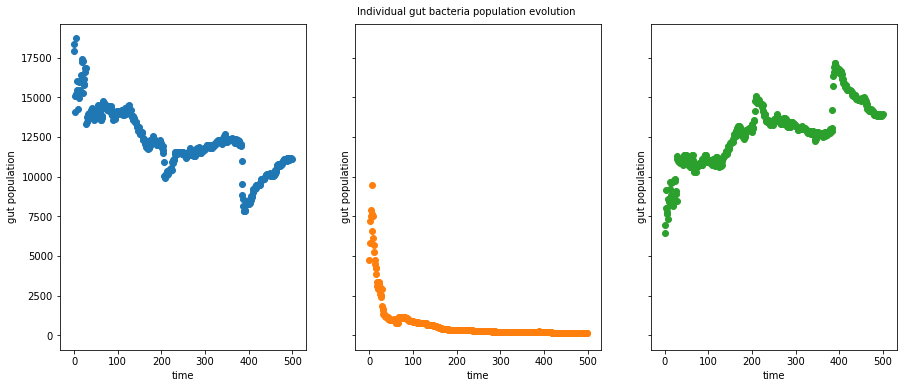

In [18]:
plotPopulation()


In [19]:
#@title
# one scatter plot for state history. 
# relevant to trace out the population evolution across timesteps.

def plotState():

  X = np.arange(sel.size)
  fig,ax = plt.subplots(nrows,ncols,sharex = True, sharey = True,figsize = (15,6))
  cm = plt.get_cmap("tab10")
  ax = ax.ravel()

  for i in range(gut.nBacteria):
    ax[i].scatter(X,stateHistory[sel,i],color = cm(i))
    ax[i].set_ylabel("cravings")
    ax[i].set_xlabel("time")

  fig.text(0.4,0.9,"Individual state history")
  if saveFig:
    plt.savefig(folder+'scatter-state'+str(sim_num)+'.'+fileFormat,bbox_inches = 'tight',format= fileFormat)
    

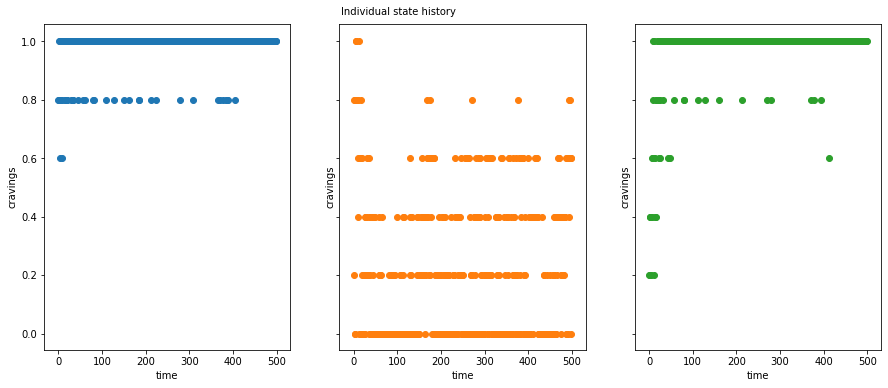

In [20]:
plotState()

In [21]:
#@title
# plotting reward history
def plotReward():    
  plt.scatter(range(sel.size),rewardHistory[sel])
  plt.xlabel("time")
  plt.ylabel("normalized reward")
  if saveFig:
    plt.savefig(folder+'reward'+str(sim_num)+'.'+fileFormat,bbox_inches = 'tight',format= fileFormat)
          

In [22]:
#@title
# Behavior history for each bacterium - whether the bacteria received the nutrient or not. 
# yellow represents higher values (or presence of nutrient to the bacteria)
# width of heat map

def plotBehavior():
  a = behaviorHistory
  height = int(0.9*len(behavior.stateSet)//len(behavior.actionSet)) #height of the heat map
  fig,ax = plt.subplots(nrows,ncols,sharey = True,sharex = True,figsize = (50,50))
  ax = ax.ravel()

  for i in range(gut.nBacteria):
    ax[i].imshow(np.tile(a[sel,i],(height,1)))
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    ax[i].set_title("nutrient "+str(i+1))
  fig.text(0.3,0.3,"time steps (whether with time, nutrients were being ingested or not?)")
  if saveFig:
    plt.savefig(folder+'nutrient-behavior'+str(sim_num)+'.'+fileFormat,bbox_inches = 'tight',format= fileFormat)

In [23]:
#@title
# Qtable heat map

def plotQTable():
  nstates = len(behavior.stateSet)
  nactions = len(behavior.actionSet)
  expansion = 0.5*nstates//nactions


  actions = behavior.actionSet
  states = [behavior.stateSet[int(i)] for i in np.linspace(0,nstates,behavior.stateSlicer+1)[:-1]]

  fig,ax = plt.subplots(1,1,figsize = (20,20))
  ax.imshow(np.repeat(brain.qTable,expansion,1))

  ax.set_xticks(np.linspace(0,nactions*expansion-1,nactions+1))
  ax.set_xticklabels(actions,rotation = 45,fontsize = 6)

  ax.set_yticks(np.linspace(0,nstates,behavior.stateSlicer+1))
  ax.set_yticklabels(states,rotation = 90,fontsize = 6)

  ax.set_xlabel("actions")
  ax.set_ylabel("states")

  if saveFig:
    plt.savefig(folder+'qtable'+str(sim_num)+'.'+fileFormat,bbox_inches = 'tight',format = fileFormat)

In [24]:
#@title
# plot action history to check the stagnation towards the end

def plotActionHistory():
  X = np.arange(sel.size)

  fig,ax = plt.subplots(1,1,sharex = True, sharey = True,figsize = (15,6))
  cm = plt.get_cmap("tab10")

  act_ind = []
  actions = behavior.actionSet
  for a in actionHistory[sel]:
    act_ind.append(np.where((a == actions).all(1))[0][0])


  plt.scatter(X,act_ind,c = np.tile(range(20),len(X)//20),cmap = plt.get_cmap())
  plt.ylabel("Action")
  plt.xlabel("Time")
  plt.colorbar()
  plt.yticks(range(16),actions) 
  fig.text(0.5,0.9,"Action History")

  if saveFig:
    plt.savefig(folder+'action-history'+str(sim_num)+'.'+fileFormat,bbox_inches = 'tight',format= fileFormat)

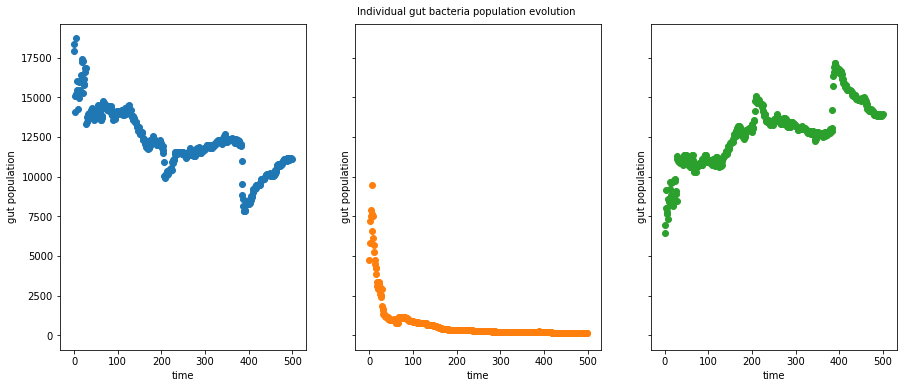

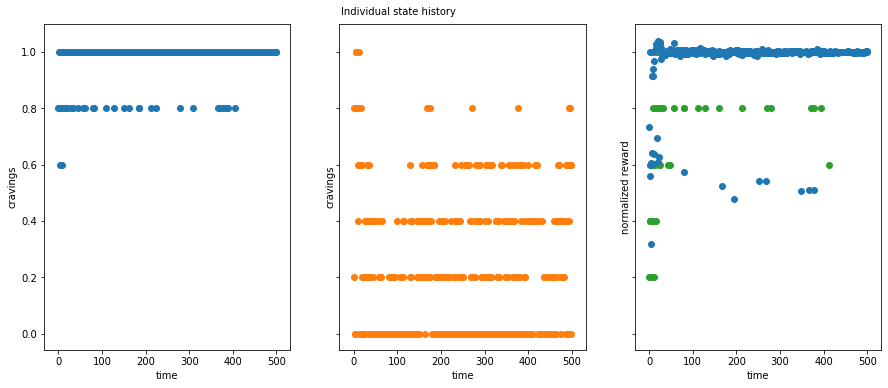

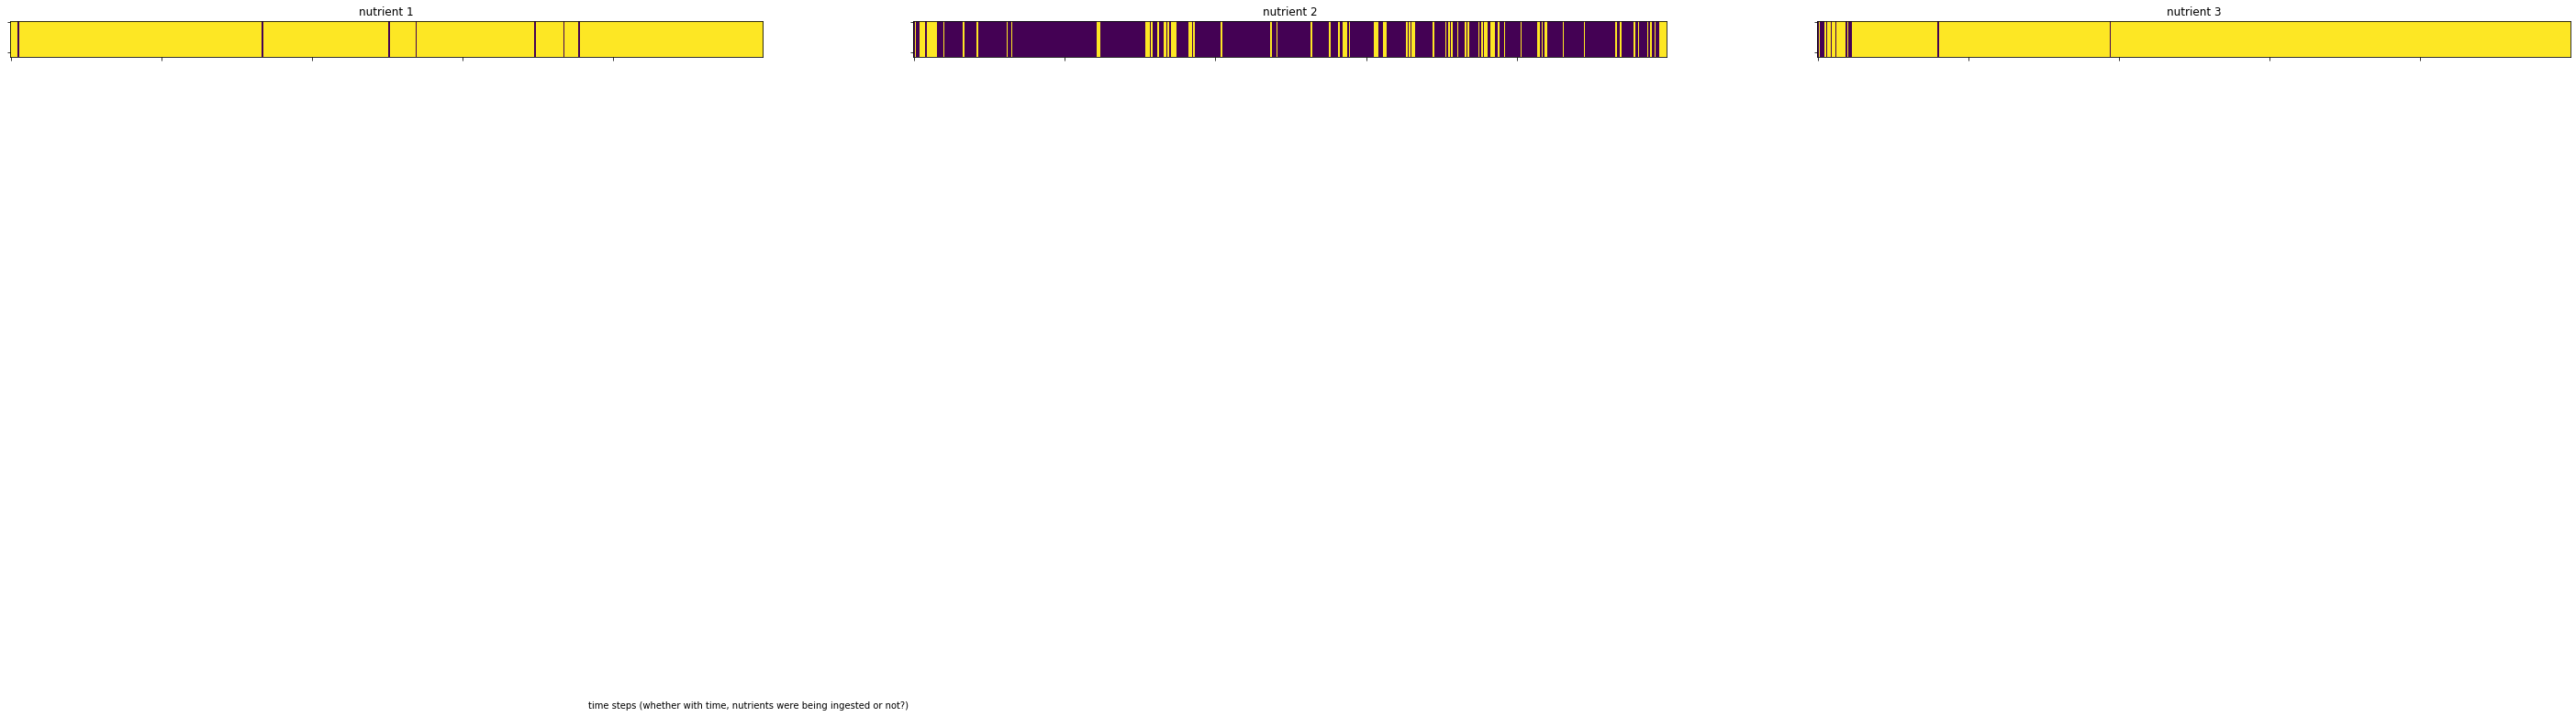

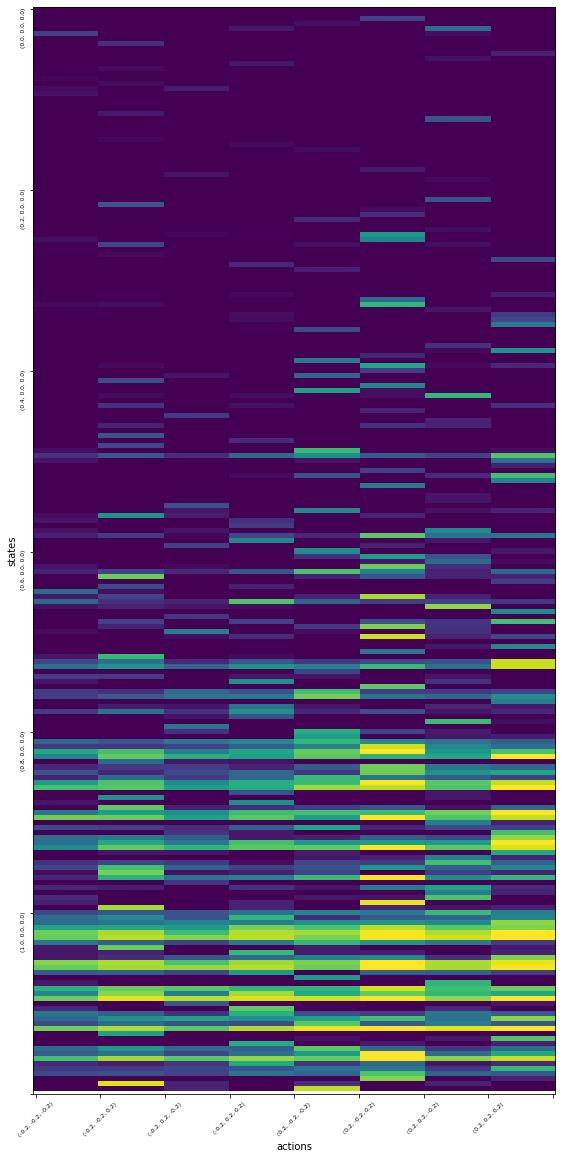

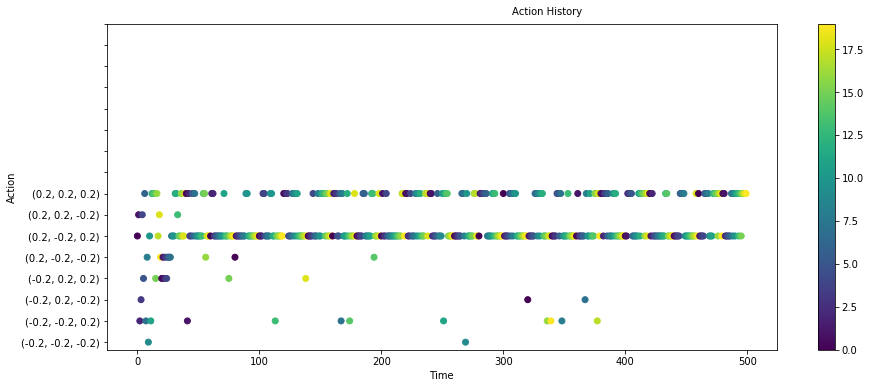

In [25]:
plotPopulation()
plotState()
plotReward()
plotBehavior()
plotQTable()
plotActionHistory()


In [27]:
stateHistory.mean(axis = 0)

array([0.9828748, 0.2206004, 0.9697244])